In [177]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sidetable
import glob
import pathlib as path
pd.options.display.float_format = '{:,.2f}'.format

# Captación de la información del sistema de directorios 

In [5]:
ruta = path.Path.cwd() / '00 - datasets' / 'datasets' / 'babynames'

In [6]:
def process_file(ruta):
    ''' Esta función sirve para procesar los ficheros individualmente antes de procesarlos. Debiera
        ser más rapida que el realizar el proceso sobre el fichero completo, ya que podrá optimizar
        mejor el uso de memoria RAM en ficheros más pequeños.
        Hay operaciones que nos se pueden hacer a este nivel y se pasan al nivel agregado.
    '''
    df = (
        pd.read_csv(ruta, delimiter=',', names=['Name', 'Sex', 'Number'])
        .assign(Year=ruta.name[3:7])  # year processing for including in df
        .pipe(lambda df_: df_[['Year', 'Sex', 'Name', 'Number']])
    )
    return df

In [186]:
# Realizo el empalmado de todos los ficheros ya preparados por la función de procesado
# y realizo las últimas tareas de ordenación de ficheros.
all_files = list(ruta.glob('*.txt'))
dflist = (process_file(f) for f in all_files)
df = (
    pd.concat(dflist, ignore_index=True)
    .sort_values(['Year', 'Sex', 'Number'])
    .reset_index()
    .drop('index', axis=1)
)
df.head()

,Year,Sex,Name,Number
0,1880,F,Adelle,5
1,1880,F,Adina,5
2,1880,F,Adrienne,5
3,1880,F,Albertine,5
4,1880,F,Alys,5


In [58]:
df.stb.counts()

,count,unique,most_freq,most_freq_count,least_freq,least_freq_count
Sex,1690784,2,F,1003985,M,686799
Year,1690784,131,2008,35006,1881,1935
Number,1690784,13380,5,235691,29364,1
Name,1690784,88496,Sidney,262,Donagene,1


<AxesSubplot:xlabel='Year'>

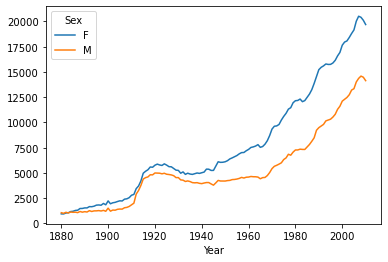

In [208]:
df.groupby(['Sex','Year'])['Name'].nunique().unstack(level=0).plot()

In [102]:
df.Number.sum()//1000000

322

In [124]:
totales = df.groupby(['Sex', 'Name'])['Number'].sum().sort_values(ascending=False)

In [121]:
df[(df['Name'].isin(['James', 'John', 'Robert', 'Michael'])) & (df['Sex'] == 'M')]

,Year,Sex,Name,Number
1954,1880,M,Michael,354
1990,1880,M,Robert,2416
1997,1880,M,James,5927
1999,1880,M,John,9655
3881,1881,M,Michael,298
...,...,...,...,...
1656943,2009,M,Michael,18822
1690730,2010,M,Robert,7471
1690758,2010,M,John,11424
1690765,2010,M,James,13714


In [187]:
cubetas = [0] + [6 * 10 ** x for x in range(7)]
grupos = pd.cut(totales, cubetas, labels=cubetas[1:])
grupos.rename('Bin', inplace=True)

Sex  Name     
M    James        6000000
     John         6000000
     Robert       6000000
     Michael      6000000
F    Mary         6000000
                   ...   
     Neatha             6
     Ned                6
     Neelee             6
     Neeru              6
     Aabriella          6
Name: Bin, Length: 98148, dtype: category
Categories (7, int64): [6 < 60 < 600 < 6000 < 60000 < 600000 < 6000000]

In [188]:
df = pd.merge(df, grupos, how='left', left_on=[
              'Sex', 'Name'], right_index=True)

In [190]:
df['Percentage'] = (df['Number'] / df.groupby(['Sex', 'Year'])
                    ['Number'].transform('sum')) * 100
df.head()

,Year,Sex,Name,Number,Bin,Percentage
0,1880,F,Adelle,5,6000,0.01
1,1880,F,Adina,5,6000,0.01
2,1880,F,Adrienne,5,600000,0.01
3,1880,F,Albertine,5,6000,0.01
4,1880,F,Alys,5,6000,0.01


<AxesSubplot:xlabel='Sex,Year'>

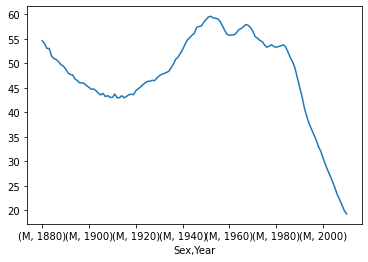

In [211]:
df[(df['Bin'] == 6000000) & (df['Sex'] == 'M')].groupby(['Sex','Year'])['Percentage'].sum().plot()

<AxesSubplot:xlabel='Year'>

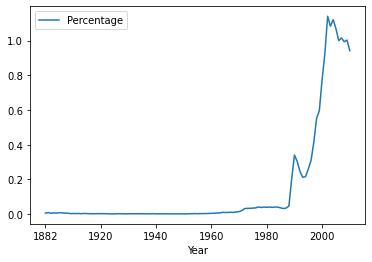

In [195]:
sns.lineplot(data=df, x='Year', y='Number', hue='Bin')